<a href="https://colab.research.google.com/github/yanada1307/14IF_Multi-label-Emotion-Classification/blob/main/Proyek_PBA_Sprinkle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **PROYEK PBA KELOMPOK SPRINKLE**
**Pemrosesan Bahasa Alami**

**Kamis, 25 November 2021**


1.   11S18015 - Yanada Sari Br Situmorang
2.   11S18002 - Putri Era Waty Bakara
3.   11S18010 - N. Priskila Napitupulu
4.   11S18012 - Suryani Vebhitry Siahaan
5.   11S18038 - Grace Winda N Naibaho
6.   11S18063 - Elyta Junetta Siregar





---

In [ ]:
!pip3 install datasets transformers -q

In [ ]:
!pip install tez

In [ ]:
from datasets import load_dataset

import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from torch.utils.data import DataLoader

import tez
import torch
import torch.nn as nn
import transformers
from sklearn import metrics, model_selection, preprocessing
from transformers import AdamW, get_linear_schedule_with_warmup

**Load dataset go_emotions dan split menjadi train, validation, dan test**

In [ ]:
go_emotions = load_dataset("go_emotions")

data = go_emotions.data

Downloading:   0%|          | 0.00/2.02k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

No config specified, defaulting to: go_emotions/simplified


Downloading:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/203k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/201k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
train = go_emotions.data["train"].to_pandas()
valid = go_emotions.data["validation"].to_pandas()
test = go_emotions.data["test"].to_pandas()

In [ ]:
print(train.shape, valid.shape, test.shape)

(43410, 3) (5426, 3) (5427, 3)


In [ ]:
train.head() 

,text,labels,id
0,My favourite food is anything I didn't have to...,[27],eebbqej
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj
3,To make her feel threatened,[14],ed7ypvh
4,Dirty Southern Wankers,[3],ed0bdzj


**Convert dataset menjadi representasi one-hot**

In [ ]:
mapping = {
    0:"admiration",
    1:"amusement",
    2:"anger",
    3:"annoyance",
    4:"approval",
    5:"caring",
    6:"confusion",
    7:"curiosity",
    8:"desire",
    9:"disappointment",
    10:"disapproval",
    11:"disgust",
    12:"embarrassment",
    13:"excitement",
    14:"fear",
    15:"gratitude",
    16:"grief",
    17:"joy",
    18:"love",
    19:"nervousness",
    20:"optimism",
    21:"pride",
    22:"realization",
    23:"relief",
    24:"remorse",
    25:"sadness",
    26:"surprise",
    27:"neutral",
}

n_labels = len(mapping)

In [ ]:
def one_hot_labels(df):
    dict_labels= []
    for i in tqdm(range(len(df))):
        d = [0]*n_labels
        labels = df.iloc[i]["labels"]
        
        for label in labels:
            d[label] = 1
        dict_labels.append(d)
        
    return pd.DataFrame(dict_labels)

In [ ]:
train_oh_labels = one_hot_labels(train)
valid_oh_labels = one_hot_labels(valid)
test_oh_labels = one_hot_labels(test)

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

In [ ]:
train_oh_labels.shape

(43410, 28)

In [ ]:
train = pd.concat([train, train_oh_labels], axis=1)
valid = pd.concat([valid, valid_oh_labels], axis=1)
test = pd.concat([test, test_oh_labels], axis=1)

**Cek kembali datanya**

In [ ]:
print(train.shape, valid.shape, test.shape)

(43410, 31) (5426, 31) (5427, 31)


In [ ]:
train.head()

,text,labels,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,My favourite food is anything I didn't have to...,[27],eebbqej,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,To make her feel threatened,[14],ed7ypvh,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Dirty Southern Wankers,[3],ed0bdzj,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


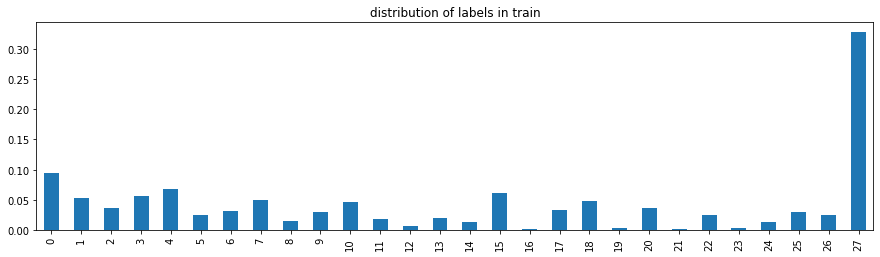

In [ ]:
fig = plt.figure(figsize=(15, 13))

ax1 = plt.subplot(3, 1, 1)
train[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax1, title="distribution of labels in train")

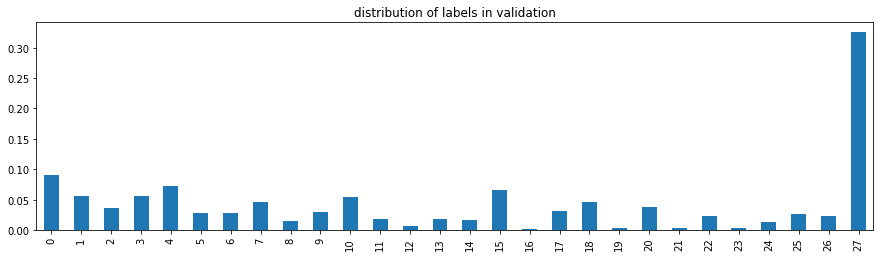

In [ ]:
fig = plt.figure(figsize=(15, 13))

ax2 = plt.subplot(3, 1, 2)
valid[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax2, title="distribution of labels in validation")

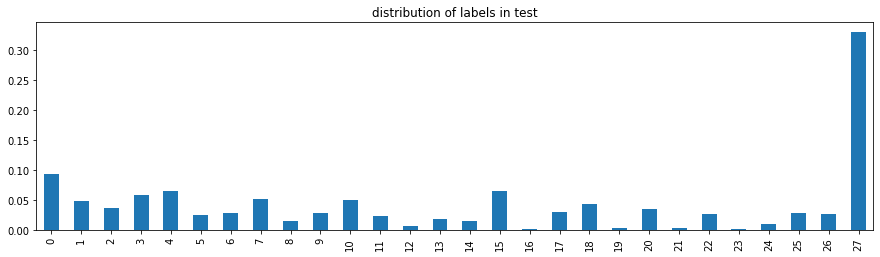

In [ ]:
fig = plt.figure(figsize=(15, 13))

ax3 = plt.subplot(3, 1, 3)
test[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax3, title="distribution of labels in test")

In [ ]:
def inspect_data(label, n=5):
    samples = train[train[label] == 1].sample(5)
    sentiment = mapping[label]
    
    print(f"examples from {sentiment}")
    print()
    for text in samples["text"]:
        print(text)
        print("---")

**Beberapa ulasan dari emotions**

In [ ]:
inspect_data(0)

examples from admiration

I was a huge fan of the script ones but the new greens this season look pretty fresh on ice, too. I like bringing the red back in
---
That woman on the left with red shirt and blue jeans looks really calm
---
Brilliant post!
---
This is amazing. Thank you for posting the link.
---
> Do you need me to link posts or something? Yep. Nice ban evasion account, by the way. 
---


In [ ]:
inspect_data(1)

examples from amusement

I like [NAME], but this entire sequence was hilarious. Poor guy. 
---
Lol, wut
---
Thankfully I had supportive and patient friends, lol.
---
> a mother in law unit Apropos of this and not the main thing.. lol! We call them granny flats in Aus :)
---
I have dayz but haven’t played in years. Last I heard it’s still a broken mess lol.
---


In [ ]:
inspect_data(2)

examples from anger

The worst is when those moments pop up randomly. Especially when you’re feeling happy and then a mistake you did back in 2005 comes creeping up.
---
And suck this guy off at the same time
---
**You are breaking the car!**
---
He doesn't He just want to get the F*** out of there.
---
Easy, stop men from fucking them. Cant be a slut if no one fucking ya right?
---


In [ ]:
inspect_data(3)

examples from annoyance

Kill all humans
---
It's not even artisanal? You're a monster.
---
Why is everyone smoking out of straws and shit?!
---
I came here to laugh at memes. Not feel feels
---
I cannot help but get a sense of schadenfreude when a seemingly shitty person ruins their own career right before my eyes. ☕️
---


In [ ]:
inspect_data(4)

examples from approval

Wait what’s wrong with [NAME] lol I’ve never had any problems listening to him personally
---
You see what I mean . This is still bullshit that people won't expect that fact the alcohol and cigarettes harm your body more than weed does
---
WW2 has the best supply drops ever
---
Yeah usually I’m defensive around people I don’t know casually walking around with things that could be powerful weapons.
---
[NAME] is retiring but I still agree with your point
---


In [ ]:
inspect_data(5)

examples from caring

Well it very well could be your drug usage. You could be depressed also. So stop doing drugs and see a therapist.
---
shitposts are hazardous to your health.
---
And please don’t make the mistake of thinking your mustache will disguise them. Trust me it doesn’t.
---
Good luck bro! I am with you on this journey. Currently on day 7. I had trouble sleeping yesterday night due to the urges.
---
Don’t worry; I’m sure your dad will come back from the store any day now.
---


**Menetukan kumpulan data PyTorch**

In [ ]:
class GoEmotionDataset():
    def __init__(self, texts, targets):
        self.texts = texts
        self.targets = targets
        self.tokenizer = transformers.SqueezeBertTokenizer.from_pretrained(
            "squeezebert/squeezebert-uncased", do_lower_case=True
        )
        self.max_len = 35
 
    def __len__(self):
        return len(self.texts)

    
    def __getitem__(self, index):
        target = self.targets[index]
        text = self.texts[index]

        inputs = self.tokenizer.encode_plus(text,
                                            None,
                                            add_special_tokens=True,
                                            max_length=self.max_len,
                                            padding="max_length",
                                            truncation=True)
        
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "targets": torch.tensor(self.targets[index], dtype=torch.long),
        }

**Mendefinisikan Tez** 

In [ ]:
class EmotionClassifier(tez.Model):
    def __init__(self, num_train_steps, num_classes):
        super().__init__()
        self.bert = transformers.SqueezeBertModel.from_pretrained("squeezebert/squeezebert-uncased")
        self.bert_drop = nn.Dropout(0.3)
        self.out = nn.Linear(768, num_classes)
        self.num_train_steps = num_train_steps
        self.step_scheduler_after = "batch"
      
    def fetch_optimizer(self):
        param_optimizer = list(self.named_parameters())
        no_decay = ["bias", "LayerNorm.bias"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.001,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        opt = AdamW(optimizer_parameters, lr=3e-5)
        return opt

    def fetch_scheduler(self):
        sch = get_linear_schedule_with_warmup(
            self.optimizer, num_warmup_steps=0, num_training_steps=self.num_train_steps
        )
        return sch
    
    def loss(self, outputs, targets):
        if targets is None:
            return None
        return nn.BCEWithLogitsLoss()(outputs, targets.float()) 
      
    def monitor_metrics(self, outputs, targets):
        if targets is None:
            return {}
        
        outputs = torch.sigmoid(outputs)
        outputs = outputs.cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()
        
        fpr_micro, tpr_micro, _ = metrics.roc_curve(targets.ravel(), outputs.ravel())
        auc_micro = metrics.auc(fpr_micro, tpr_micro)
        return {"auc": auc_micro}

    def forward(self, ids, mask, targets=None):
        o_2 = self.bert(ids, attention_mask=mask)["pooler_output"]
        b_o = self.bert_drop(o_2)
        output = self.out(b_o)
        loss = self.loss(output, targets)
        acc = self.monitor_metrics(output, targets)
        return output, loss, acc

**Melai Pelatihan**

In [ ]:
train_dataset = GoEmotionDataset(train.text.tolist(), train[range(n_labels)].values.tolist())
valid_dataset = GoEmotionDataset(valid.text.tolist(), valid[range(n_labels)].values.tolist())

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/500 [00:00<?, ?B/s]

In [ ]:
n_train_steps = int(len(train) / 32 * 10)
model = EmotionClassifier(n_train_steps, n_labels)

tb_logger = tez.callbacks.TensorBoardLogger(log_dir="logs/")
es = tez.callbacks.EarlyStopping(monitor="valid_loss", model_path="export/model.bin")

Downloading:   0%|          | 0.00/98.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at squeezebert/squeezebert-uncased were not used when initializing SqueezeBertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing SqueezeBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SqueezeBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model.fit(train_dataset,
          valid_dataset, 
          train_bs=64,
          device="cuda", 
          epochs=8, 
          callbacks=[tb_logger, es], 
          fp16=True, 
          n_jobs=10)

In [ ]:
test_dataset = GoEmotionDataset(test.text.tolist(), test[range(n_labels)].values.tolist())
dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=False)

**Evaluasi pada test set**

In [ ]:
outputs = []

with torch.no_grad():
    for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        output, loss, acc = model.forward(batch["ids"].to("cuda"), 
                                          batch["mask"].to("cuda"), 
                                          batch["targets"].to("cuda")
                                         )
        outputs.append(output)

In [ ]:
outputs = torch.cat(outputs)
outputs = torch.sigmoid(outputs)
outputs = outputs.cpu().detach().numpy()

In [ ]:
roc_metrics = []

for i in range(n_labels):
    roc = metrics.roc_auc_score(test[i].values, outputs[:, i])
    roc_metrics.append(roc)

s = pd.Series(roc_metrics, index=range(n_labels))

s.plot(kind="bar", figsize=(20, 5), title="roc auc score per class on test data", grid=True)

**Test beberapa kalimat**

In [ ]:
tokenizer = transformers.SqueezeBertTokenizer.from_pretrained(
            "squeezebert/squeezebert-uncased", do_lower_case=True
        )

In [ ]:
def score_sentence(text, topn=5):
    max_len = 35
    with torch.no_grad():

In [ ]:
inputs = tokenizer.encode_plus(text,
                                       None,
                                       add_special_tokens=True,
                                       max_length=max_len,
                                       padding="max_length",
                                       truncation=True)

        ids = inputs["input_ids"]
        ids = torch.LongTensor(ids).cuda().unsqueeze(0)

        attention_mask = inputs["attention_mask"]
        attention_mask = torch.LongTensor(attention_mask).cuda().unsqueeze(0)

In [ ]:
        output = model.forward(ids, attention_mask)[0]
        output = torch.sigmoid(output)

        probas, indices = torch.sort(output)

    probas = probas.cpu().numpy()[0][::-1]
    indices = indices.cpu().numpy()[0][::-1]

    for i, p in zip(indices[:topn], probas[:topn]):
        print(mapping[i], p)